## Working with a 3D large eddy simulation of shallow convection

### The simulation

* Objective: compare a single column of a GCM with large eddy simlations for three different cloud types (stratus, stratocumulus, trade cumulus)

[GCM paper](http://ezproxy.library.ubc.ca/login?url=http://doi.wiley.com/10.1002/jame.v5.4)

[LES paper](http://ezproxy.library.ubc.ca/login?url=http://doi.wiley.com/10.1002/jame.20025)

* We started with the trade cumulus simulation, then perturbed it by raising the temperature to 300 K and 301 K.

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_ctl_s6_synthetic_albedo.mp4

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_sst_300K_synthetic_albedo.mp4

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_sst_301K_synthetic_albedo.mp4


###  The dataset  -- netccdf

[An example of reading a netCDF4 file ](http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html)


In [1]:
import glob
from netCDF4 import Dataset
from a405utils.ncdump import ncdump
from a405utils.download import download_file

download = False
if download:
    #
    #  satelite data for day 127 of 2014  Modis Aqua level 3 cloud data
    #
    url = 'http://clouds.eos.ubc.ca/~phil/Downloads/a405/ENT_CGILS_CTL_S6_3D_384x384x194_25m_1s_96_0000014160.nc'
    local_file = download_file(url)
    print('downloaded {}'.format(local_file))
    
the_file = glob.glob("*CTL*")[0]
with Dataset(the_file,'r') as ncin:
    ncdump(ncin)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: x
		size: 384
		type: dtype('float32')
		units: 'm'
	Name: y
		size: 384
		type: dtype('float32')
		units: 'm'
	Name: z
		size: 194
		type: dtype('float32')
		units: 'm'
		long_name: 'height'
	Name: time
		size: 1
		type: dtype('float32')
		units: 'd'
		long_name: 'time'
NetCDF variable information:
	Name: p
		dimensions: ('z',)
		size: 194
		type: dtype('float32')
		units: 'mb'
		long_name: 'pressure'
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'X Wind Component                                                                '
		units: 'm/s       '
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'Y Wind Component                                                                '
		units: 'm/s       '
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'Z Wind Compone

### liquid water cross section at 1 km



In [2]:
def get_var(the_file,varname):
    with Dataset(the_file) as ncin:
         out=ncin.variables[varname][...]
         x = ncin.variables['x'][...]
         y = ncin.variables['y'][...]
         z = ncin.variables['z'][...]
         out = out.squeeze()  #remove the time dimension, since we only have one timestep
    return x,y,z,out
x,y,z,qn = get_var(the_file, 'QN')

In [3]:
#
#  find the index for z = 1000 meters
#

level = np.searchsorted(z, 1000)

In [4]:
#
# get the cloud liquid water at 1000 m
#
horiz_cross_sec = qn[level,:,:]
#
# find the cross section cloud fraction
#
cloud_frac=np.sum(horiz_cross_sec > 0)/horiz_cross_sec.size
print('cloud fraction: {:5.3f}'.format(cloud_frac))

cloud fraction: 0.050


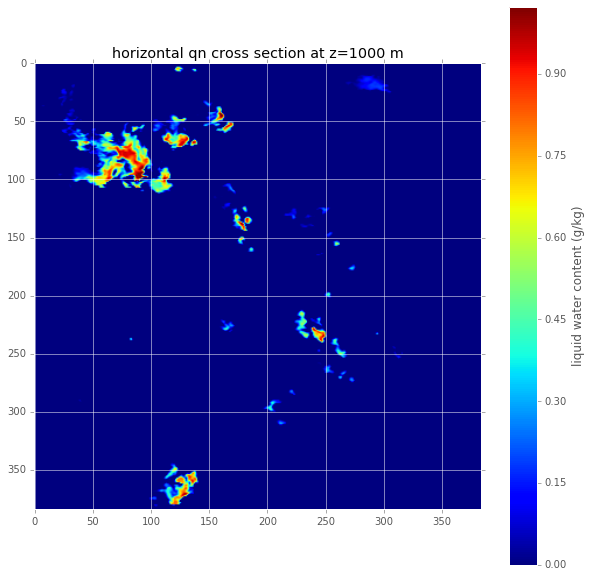

In [5]:
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot as plt
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(10,10))
whole_scene=ax.imshow(horiz_cross_sec)
cax=plt.colorbar(whole_scene,ax=ax)
cax.set_label('liquid water content (g/kg)')
title = 'horizontal qn cross section at z=1000 m'
ax.set_title(title)

### zoom in on  the top left corner

Switch from [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) to 
[pcolormesh](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pcolormesh) so we can orient the axes along model x,y, and z coordinates.  Note that if y is north/south (north up), then imshow plots the image upside down.

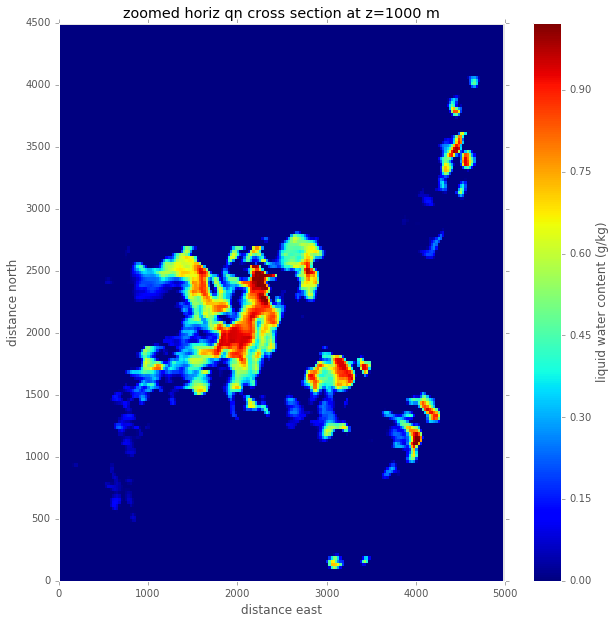

In [6]:
#
# it helps in checking your orientation to make the selection
# have different numbers of rows and columns
#
end_col = 200
end_row = 180
fig,ax =plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],y[:end_row],horiz_cross_sec[:end_row,:end_col])
ax.set(xlabel='distance east',ylabel='distance north')
cax = plt.colorbar(image,ax=ax)
cax.set_label('liquid water content (g/kg)')
ax.set_title('zoomed horiz qn cross section at z=1000 m')

### Get a vertical cross section along y = 2km

In [7]:
row_number = np.searchsorted(y,2000)  #(y index of 80)

In [8]:
row_number

80

(194, 200)
194 200


[<matplotlib.text.Text at 0x7d4c320>, <matplotlib.text.Text at 0x7e3fcc0>]

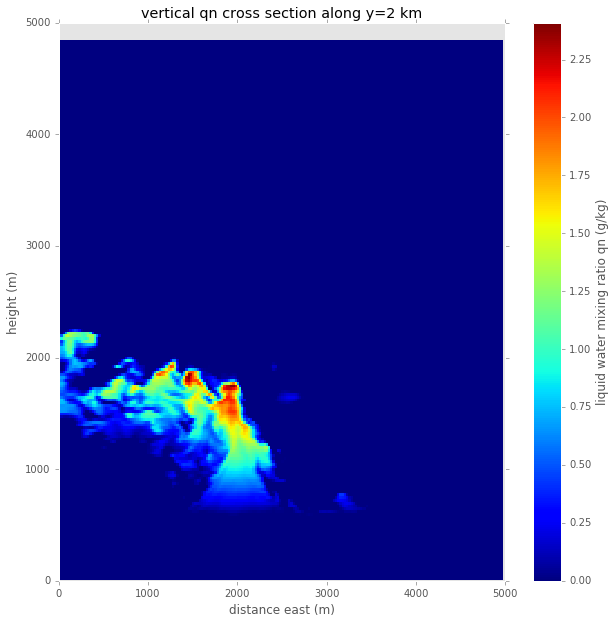

In [9]:
vert_cross_sec = qn[:,row_number,:end_col]    #height, y, x --> y is the row, x is the column!!!
print(vert_cross_sec.shape)
print(len(z),len(x[:end_col]))
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('liquid water mixing ratio qn (g/kg)')
ax.set_title('vertical qn cross section along y=2 km')
ax.set(xlabel='distance east (m)',ylabel='height (m)')

### Find the vapor mixing ratio along this cross section

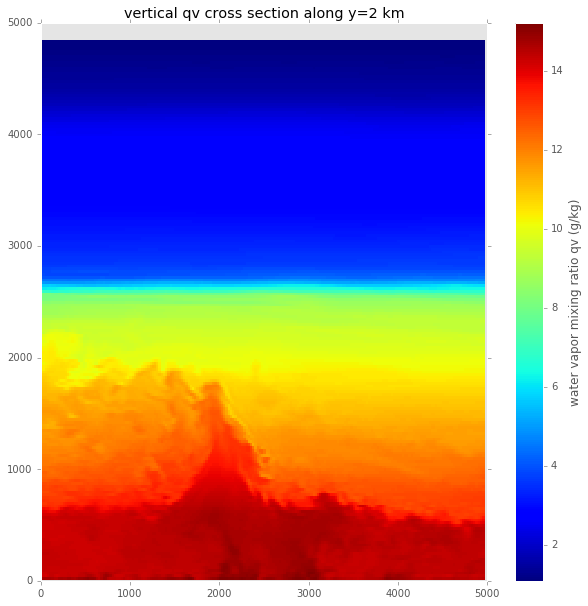

In [10]:
plt.close('all')
x,y,z,qv = get_var(the_file, 'QV')
vert_cross_sec = qv[:,row_number,:end_col]
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('water vapor mixing ratio qv (g/kg)')
ax.set_title('vertical qv cross section along y=2 km')

### For Monday

1\.  Read Thompkins chapter 4 parameterization notes through section 4.7.1

2\.  Read [Zhu and Randall, 1996](http://kiwi.atmos.colostate.edu/pubs/XuandRandall-semiempirical-1996.pdf)

3\.  Hand in a notebook that adds cells to cgilsI.ipynb to:

     * use pcolormesh to plot a vertical cross section of the relative humidity for along y=2 km, x= 0-5 km
     
     * use plot to plot a vertical profile of the horizontal mean RH in for this cross section as a function of height
     
     * use plot to plot a vertical profile of the horizontal standard deviation of RH as a function of height

Call rsat to get relative humidity, using temperature and pressure and specific humidity (just use qv as mixing ratio). Find the saturation mixing ratio, divide the specific vapour mixing ratio by that to get relative humidity. Want the mean and standard deviation. No need to loop - every variable has a method called mean and a method called var, e.g. qn.mean() and qn.sd(), (or qn.var() and take the square root of qn.sd() doesn't work) with z, y, x being the order, so put axis = 0 for z, axis = 1 for y, axis = 2 for x inside the brackets. So, ex. qn.mean(axis=0) for the average over z. Vertical profile of mean RH and vertical profile of standard deviation of RH. 

## 1. Use pcolormesh to plot a vertical cross section of the relative humidity for y = 2 km, x = 0-5 km.

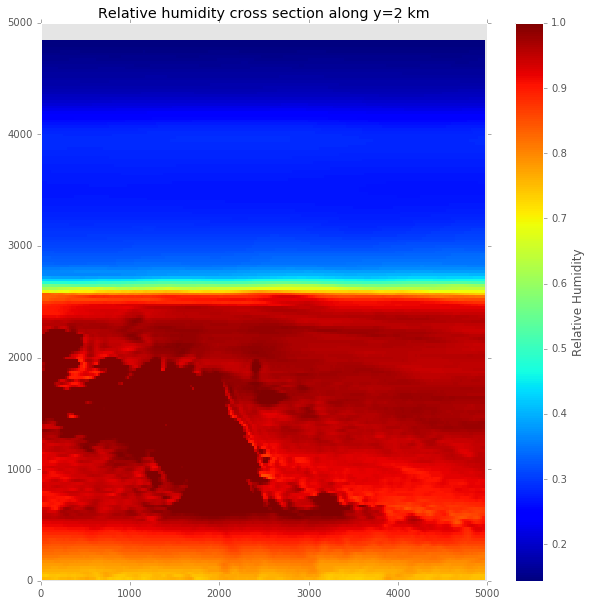

In [11]:
from a405thermo.thermlib import find_rsat

x, y, z, temp = get_var(the_file, 'TABS')
vert_cross_sec_temp = temp[:, row_number, :end_col]
x, y, z, press = get_var(the_file, 'p')

vert_cross_sec_qv = vert_cross_sec*1.e-3

rsat_list = []

for i in range(0, 194):
    rsat = find_rsat(vert_cross_sec_temp[i, :], press[i]*1.e2)
    rsat_list.append(rsat)
rsat_array = np.asarray(rsat_list)

relhum_list = []

for i in range(0, 194):
    relhum = vert_cross_sec_qv[i, :]/rsat_array[i, :]
    relhum_list.append(relhum)
relhum_array = np.asarray(relhum_list)

fig,ax = plt.subplots(1,1, figsize = (10,10))
image = ax.pcolormesh(x[:end_col], z, relhum_array[:, :end_col])
cax = plt.colorbar(image, ax = ax)
cax.set_label('Relative Humidity')
ax.set_title('Relative humidity cross section along y=2 km')

## 2. Use plot to plot a vertical profile of the horizontal mean RH for this cross section as a function of height.

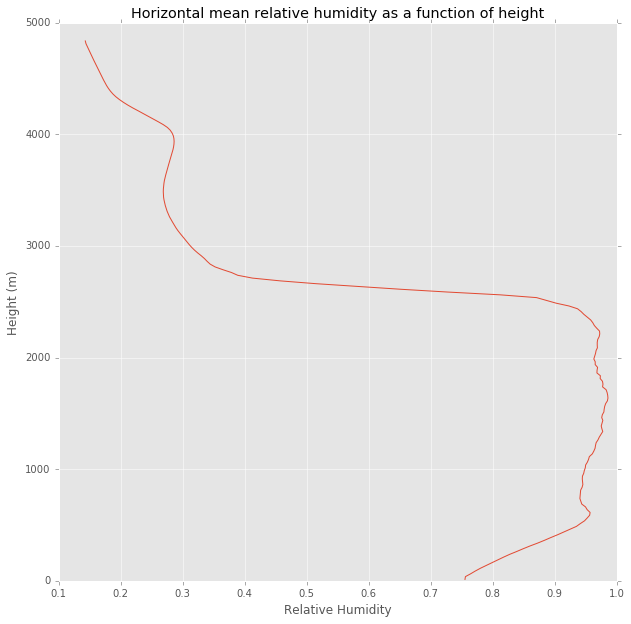

In [12]:
mean_relhum = relhum_array.mean(axis = 1)
fig,ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(mean_relhum, z)
out = ax.set(xlabel = "Relative Humidity", ylabel = "Height (m)", 
             title = "Horizontal mean relative humidity as a function of height")

## 3. Use plot to plot a vertical profile of the horizontal standard deviation of RH as a function of height.

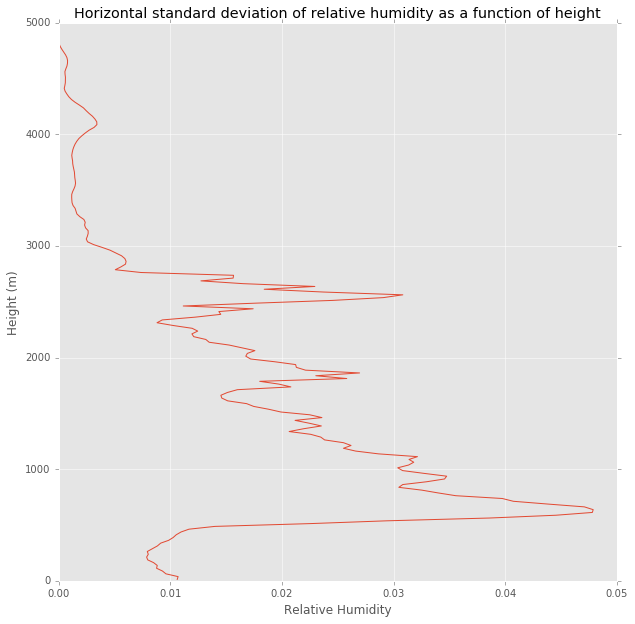

In [13]:
sd_relhum = (relhum_array.var(axis = 1))**0.5
fig,ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(sd_relhum, z)
out = ax.set(xlabel = "Relative Humidity", ylabel = "Height (m)", 
             title = "Horizontal standard deviation of relative humidity as a function of height")

# ATSC Day 35 Assignment
We've used $\theta_e$ and $q_T$ so that they are conserved as a function of pressure for adiabatic processes (only influenced by mixing). Zhu and Randall use $\theta_l$ instead. Start with $w_T$ is all liquid. Recall $h_m=c_pT+l_vw_v+q_z$. The first term is the amount of energy it took to warm the liquid; the second term is the amount of energy it took to evaporate the liquid; and the third term is a potential energy term related to moving to a new height $z$. Alternatively, suppose $w_T$ is initially all vapour. Then you condense into liquid form, and use $h_l$ instead.

Do Fig. 1 from Zhu and Randall, $\theta_e$ and $q_T$ on y and x axes, respectively. To get the saturation line you have to compute $r_s$, but don't worry about doing that yourself. For histograms, use perturbations to take mean values out. For scatterplot, look up np.random to randomly sample integers from your dataset so that you're not plotting the whole thing. Don't worry about levels anymore - as long as you're below 2500 m, flatten 3-D arrays into 1-D with no $z$ component.

ATSC 405 exam - on April 13th from 11:00 AM - 1:30 PM. Coding portion assigned the morning of Sunday April 17th and due Tuesday April 19th at 10:00 PM.

## 1. Find $\theta_e$ and $q_T$ for our LES below $z=2500$ m.

In [16]:
newlevel = np.searchsorted(z, 2500)
print(newlevel)

100


In [39]:
from a405thermo.thermlib import find_Td

vert_cross_sec_qn = qn[:newlevel, row_number, :end_col]*1.e-3
vert_cross_sec_qv = qv[:newlevel, row_number, :end_col]*1.e-3

dewpoint_list = []

for i in range(0, 100):
    dewpoint = find_Td(vert_cross_sec_qv[i, :], press[i]*1.e2)
    dewpoint_list.append(dewpoint)
dewpoint_array = np.asarray(dewpoint_list)
dewpoint_array = dewpoint_array[1]
print(dewpoint_array.shape)

vert_cross_sec_qn = vert_cross_sec_qn[1]
vert_cross_sec_qv = vert_cross_sec_qv[1]
print(vert_cross_sec_qn.shape)
print(vert_cross_sec_qv.shape)

(200,)
(200,)
(200,)


In [40]:
newlevel_press = press[:newlevel]
newlevel_temp = temp[:newlevel, row_number, :end_col]
newlevel_temp = newlevel_temp[1]
print(newlevel_press.shape)
print(newlevel_temp.shape)

(100,)
(200,)


In [41]:
#Find q_T - this is q_v + q_n

vert_cross_sec_qt = vert_cross_sec_qn + vert_cross_sec_qv
print(vert_cross_sec_qt.shape)

(200,)


In [48]:
#Find theta_et

from a405thermo.thermlib import find_thetaet

thetaet_list = []

for i in range(0,100):
    thetaet = find_thetaet(dewpoint_array[i], vert_cross_sec_qt[i], newlevel_temp[i], newlevel_press[i]*1.e2)
    thetaet_list.append(thetaet)
thetaet_array = np.asarray(thetaet_list)
print(thetaet_array.shape)

(100,)


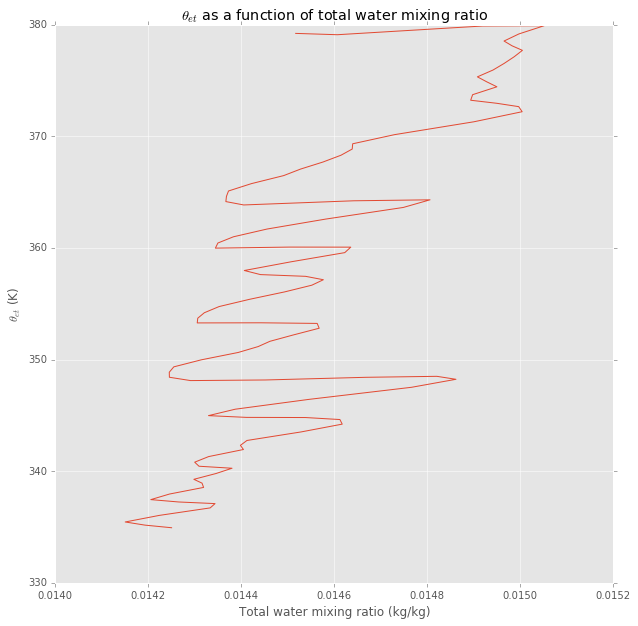

In [51]:
fig,ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(vert_cross_sec_qt[:100], thetaet_array)
out = ax.set(xlabel = "Total water mixing ratio (kg/kg)", ylabel = "$\\theta_{et}$ (K)", 
             title = "$\\theta_{et}$ as a function of total water mixing ratio")